### TODO
- Denoising AE
- Try passing attention 
    - https://arxiv.org/pdf/1612.03928v1.pdf
    - https://github.com/szagoruyko/attention-transfer

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import keras
from keras import backend

import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

import tensorflow as tf
from tensorflow.python.platform import app
from tensorflow.python.platform import flags

from cleverhans.utils_mnist import data_mnist, model_mnist
from cleverhans.utils_tf import model_train, model_eval, batch_eval
from cleverhans.attacks import fgsm, jsma
from cleverhans.attacks_tf import jacobian_graph
from cleverhans.utils import other_classes

FLAGS = flags.FLAGS

Using TensorFlow backend.


In [2]:
FLAGS.nb_epochs = 6
FLAGS.train_dir = '/tmp'
FLAGS.filename = 'mnist.ckpt'
FLAGS.batch_size = 128
FLAGS.learning_rate = 0.1

FLAGS.nb_classes = 10
FLAGS.source_samples = 5
FLAGS.img_rows = 28
FLAGS.img_cols = 28

FLAGS.max_steps = 10000
FLAGS.log_dir = "./logs/"

In [3]:
def evaluate():
    # Evaluate the accuracy of the MNIST model on legitimate test examples
    accuracy = model_eval(sess, x, y, predictions, X_test, Y_test)
    assert X_test.shape[0] == 10000, X_test.shape
    print('Test accuracy on legitimate test examples: ' + str(accuracy))
    return accuracy
    
def evaluate_2():
    # Evaluate the accuracy of the adversarialy trained MNIST model on
    # legitimate test examples
    accuracy = model_eval(sess, x, y, predictions_2, X_test, Y_test)
    print('Test accuracy on legitimate test examples: ' + str(accuracy))

    # Evaluate the accuracy of the adversarially trained MNIST model on
    # adversarial examples
    accuracy_adv = model_eval(sess, x, y, predictions_2_adv, X_test, Y_test)
    print('Test accuracy on adversarial examples: ' + str(accuracy_adv))

In [4]:
# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# Set tensorboard
keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

# Image dimensions ordering should follow the Theano convention
if keras.backend.image_dim_ordering() != 'th':
    keras.backend.set_image_dim_ordering('th')
    print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' to 'th', temporarily setting to 'tf'")

# Create TF session and set as Keras backend session
sess = tf.Session()
keras.backend.set_session(sess)

# Get MNIST test data
X_train, Y_train, X_test, Y_test = data_mnist()

assert Y_train.shape[1] == 10.
label_smooth = .1
Y_train = Y_train.clip(label_smooth / 9., 1. - label_smooth)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [15]:
# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, 1, 28, 28))
y = tf.placeholder(tf.float32, shape=(None, 10))

# Define TF model graph
model = model_mnist()
predictions = model(x)
print("Defined TensorFlow model graph.")

Defined TensorFlow model graph.


In [16]:
# Train an MNIST model
model_train(sess, x, y, predictions, X_train, Y_train, evaluate=evaluate)

Epoch 0
	Epoch took 7.29948091507 seconds
Test accuracy on legitimate test examples: 0.9548
Epoch 1
	Epoch took 7.2548148632 seconds
Test accuracy on legitimate test examples: 0.9703
Epoch 2
	Epoch took 7.21154403687 seconds
Test accuracy on legitimate test examples: 0.9784
Epoch 3
	Epoch took 7.17755413055 seconds
Test accuracy on legitimate test examples: 0.9801
Epoch 4
	Epoch took 7.24393296242 seconds
Test accuracy on legitimate test examples: 0.9818
Epoch 5
	Epoch took 7.15335202217 seconds
Test accuracy on legitimate test examples: 0.9849
Completed model training.


True

## Apply FGSM

### Create Adversarials

In [17]:
# Craft adversarial examples using Fast Gradient Sign Method (FGSM)
adv_x = fgsm(x, predictions, eps=0.2)
X_test_adv, = batch_eval(sess, [x], [adv_x], [X_test])
assert X_test_adv.shape[0] == 10000, X_test_adv.shape

# Evaluate the accuracy of the MNIST model on adversarial examples
accuracy = model_eval(sess, x, y, predictions, X_test_adv, Y_test)
print('Test accuracy on adversarial examples: ' + str(accuracy))

Test accuracy on adversarial examples: 0.0739


In [18]:
np.save('adversarials.npy', X_test_adv)

### Visualize

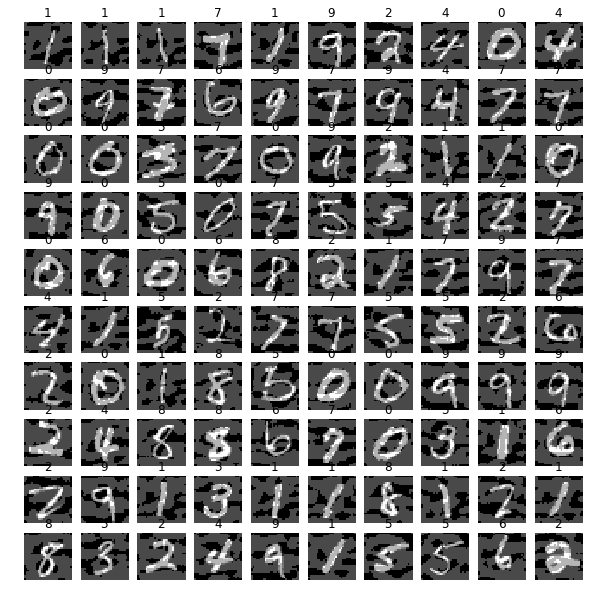

In [19]:
# sample a set 
idxs = np.random.choice(range(10000), 100)
X_test_adv_sample = X_test_adv[idxs]
Y_test_sample = Y_test[idxs]

# plot the sample set
plt.figure()
for c,img in enumerate(X_test_adv_sample):
    plt.subplot(10,10,c+1)
    plt.axis("off")
    plt.title(np.argmax(Y_test_sample[c]))
    plt.imshow(img.squeeze(), cmap=plt.cm.gray)

### Embedding

In [20]:
# Plotting function
# plt.rc('font', **{'family' : 'sans-serif',
#                          'weight' : 'bold',
#                          'size'   : 18})
# plt.rc('text', **{'usetex' : True})

def plot_mnist(X, y, X_embedded, name, min_dist=10.0):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(frameon=False)
    plt.title("\\textbf{MNIST dataset} -- Two-dimensional "
          "embedding of 70,000 handwritten digits with %s" % name)
    plt.setp(ax, xticks=(), yticks=())
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=y, marker="x")

    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = np.array([[15., 15.]])
        indices = np.arange(X_embedded.shape[0])
        np.random.shuffle(indices)
        for i in indices[:5000]:
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X[i].reshape(28, 28),
                                      cmap=plt.cm.gray_r), X_embedded[i])
            ax.add_artist(imagebox)

In [21]:
from keras.models import Model

# create feature extractor
model_feat = Model(input=model.input, output=model.get_layer('flatten_3').output)

In [22]:
# extract last layer features
X_test_feats = model_feat.predict(X_test)
X_test_adv_feats   = model_feat.predict(X_test_adv)
assert(X_test_feats.shape == X_test_adv_feats.shape)

# concate normal and adversarial features
X_feats = np.concatenate([X_test_feats, X_test_adv_feats], axis=0)
Y_feats = np.concatenate([Y_test, Y_test]).argmax(1)
images = np.concatenate([X_test,X_test_adv], axis=0)

In [23]:
from tsne import bh_sne

# train tsne projection
vis_data = bh_sne(X_feats.astype('float64'))

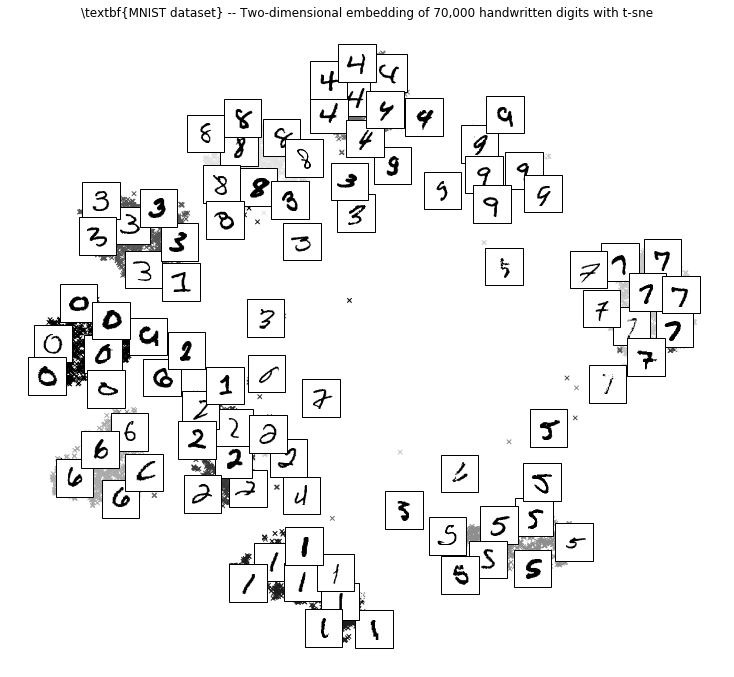

In [24]:
# plot normal instances
plot_mnist(images[:10000], Y_feats[0:10000], vis_data[:10000], 't-sne', min_dist=20.0)

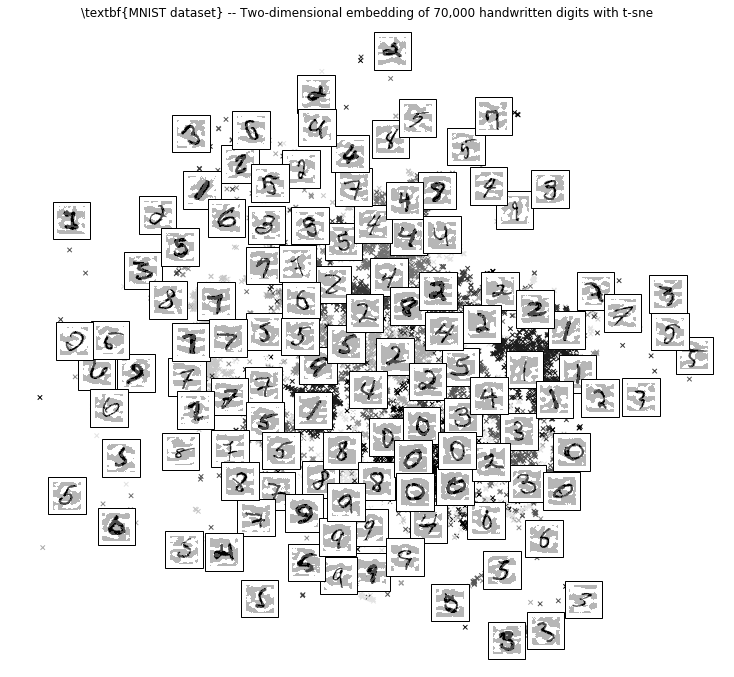

In [25]:
# plot adversarial instances
plot_mnist(images[10000:], Y_feats[10000:], vis_data[10000:], 't-sne', min_dist=20.0)

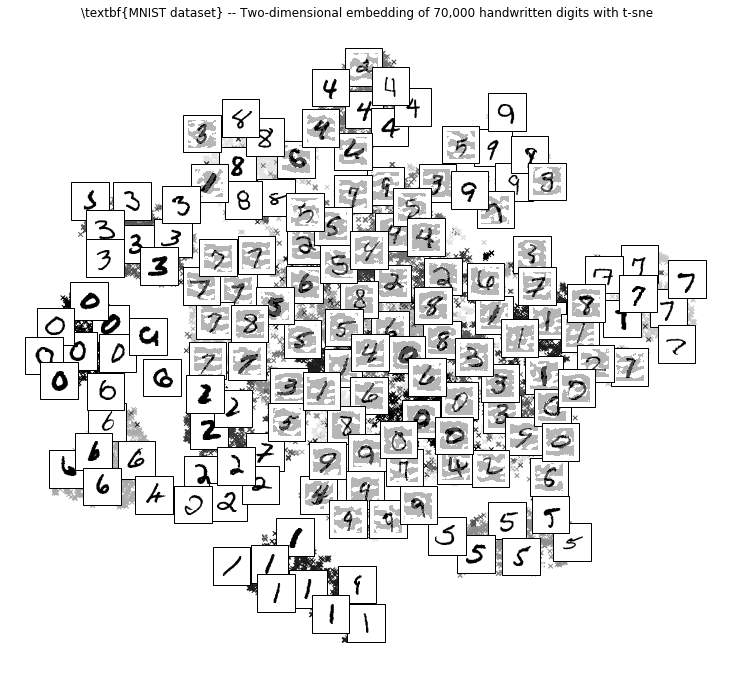

In [26]:
# plot all
plot_mnist(images, Y_feats, vis_data, 't-sne', min_dist=20.0)

### Train with Adversarials

In [ ]:
# Redefine TF model graph
model_2 = model_mnist()
predictions_2 = model_2(x)
adv_x_2 = fgsm(x, predictions_2, eps=0.3)
predictions_2_adv = model_2(adv_x_2)

# Perform adversarial training
model_train(sess, x, y, predictions_2, X_train, Y_train, predictions_adv=predictions_2_adv,
        evaluate=evaluate_2)

# Evaluate the accuracy of the MNIST model on adversarial examples
accuracy = model_eval(sess, x, y, predictions_2, X_test_adv, Y_test)
print('Test accuracy on adversarial examples: ' + str(accuracy))

## VAE

### Train a simple VAE

In [27]:
from vae import VAE

# define VAE
vae = VAE(batch_size=200, learning_rate=0.01)

In [28]:
import numpy as np
from keras.datasets import mnist

# load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# preprocess MNIST
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [29]:
vae.train(x_train, x_train, x_test, x_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s - loss: 187.9807 - val_loss: 167.8570
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 167.7718 - val_loss: 165.9555
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 164.8176 - val_loss: 164.8576
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 163.1739 - val_loss: 161.1424
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 162.0258 - val_loss: 162.6005
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 161.3512 - val_loss: 160.8553
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 160.7381 - val_loss: 164.8669
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 160.3401 - val_loss: 162.2550
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 159.9997 - val_loss: 159.2579
Epoch 10/50
60000/60000 [==============================] - 

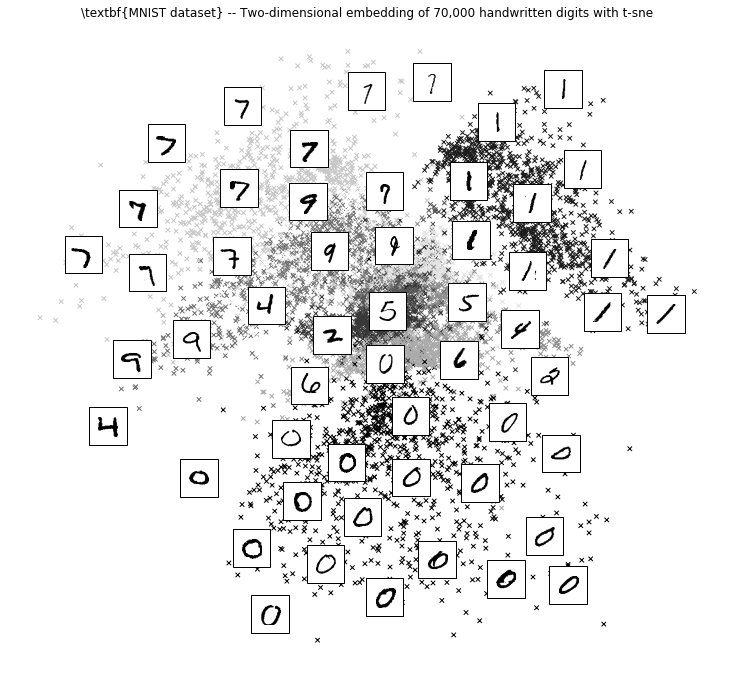

In [30]:
# encode test set to latent dimensions
x_test_feats = vae.encoder.predict(x_test, batch_size=200)

# plot test set on latent dimensions
plot_mnist(x_test, y_test, x_test_feats, 't-sne', min_dist=1.0)

### Visualize Manifold

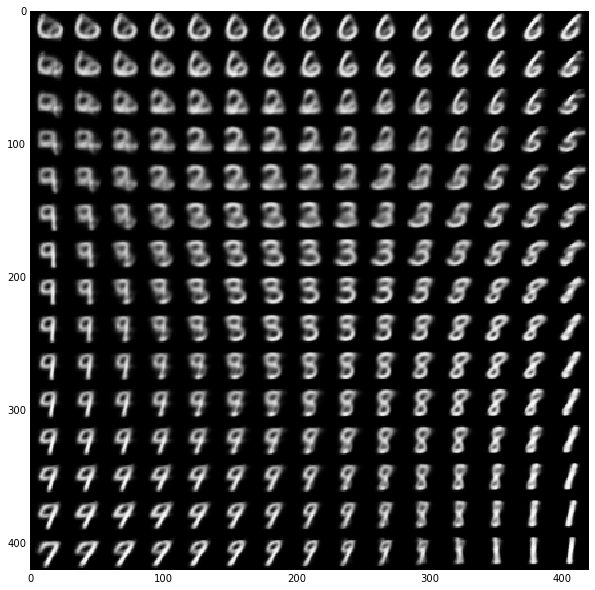

In [31]:
from scipy.stats import norm

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.generate(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### Classifiy by VAE features

I use encoded mean vectors as feature for MNIST. Then, I train a CrossEntropy classifier on top. Final values are not better than a supervised model but it is more robust to adversarial instance wihout seeing them.

Suppose to have 95% validation accuracy for normal MNIST and 34% for adversarial instances created above.

In [32]:
from vae import VAE

# create VAE model for feature learning
vae = VAE(batch_size=200, original_dim=784, latent_dim=128, intermediate_dim=512, 
          nb_epoch=50, epsilon_std=1.0, learning_rate=0.001)

In [33]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# preprocess MNIST
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# to categorical
y_train = np_utils.to_categorical(y_train, 10)
y_test  = np_utils.to_categorical(y_test, 10)

# label smooting
# label_smooth = .1
# y_train = y_train.clip(label_smooth / 9., 1. - label_smooth)

In [74]:
vae.train(x_train, x_train, x_test, x_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s - loss: 103.3219 - val_loss: 103.9988
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 103.3284 - val_loss: 103.5107
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 103.2614 - val_loss: 103.4286
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 103.2171 - val_loss: 103.2060
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 103.1704 - val_loss: 103.9105
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 103.1599 - val_loss: 103.6701
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 103.0832 - val_loss: 102.8452
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 103.0746 - val_loss: 103.9098
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 103.0004 - val_loss: 103.4584
Epoch 10/50
60000/60000 [==============================] - 

In [75]:
# compute features
x_train_feats = vae.encode(x_train)
x_test_feats = vae.encode(x_test)
# x_train_feats = vae.feat_extractor.predict(x_train, batch_size=200)
# x_test_feats  = vae.feat_extractor.predict(x_test, batch_size=200)
print(x_train_feats.shape)

(60000, 128)


In [64]:
vae.epsilon_std = 0

In [76]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.optimizers import SGD, RMSprop
from keras.regularizers import l2, activity_l2

# create classifier
clf = Sequential()
clf.add(Dense(10, input_shape=(x_train_feats.shape[1],)))
clf.add(Activation('softmax'))

# optimizer = SGD(lr=0.01, momentum=0, decay=0.0, nesterov=False)
optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
clf.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
clf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_18 (Dense)                 (None, 10)            1290        dense_input_5[0][0]              
____________________________________________________________________________________________________
activation_17 (Activation)       (None, 10)            0           dense_18[0][0]                   
Total params: 1290
____________________________________________________________________________________________________


In [77]:
# train clf
clf.fit(x_train_feats, y_train, batch_size=128, nb_epoch=10, verbose=1, 
        validation_data=[x_test_feats, y_test], shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.4850 - acc: 0.8717 - val_loss: 0.2874 - val_acc: 0.9169
Epoch 2/10
60000/60000 [==============================] - 1s - loss: 0.2839 - acc: 0.9147 - val_loss: 0.2498 - val_acc: 0.9285
Epoch 3/10
60000/60000 [==============================] - 1s - loss: 0.2568 - acc: 0.9229 - val_loss: 0.2347 - val_acc: 0.9321
Epoch 4/10
60000/60000 [==============================] - 1s - loss: 0.2415 - acc: 0.9269 - val_loss: 0.2244 - val_acc: 0.9352
Epoch 5/10
60000/60000 [==============================] - 1s - loss: 0.2313 - acc: 0.9304 - val_loss: 0.2157 - val_acc: 0.9365
Epoch 6/10
60000/60000 [==============================] - 1s - loss: 0.2232 - acc: 0.9327 - val_loss: 0.2109 - val_acc: 0.9374
Epoch 7/10
60000/60000 [==============================] - 1s - loss: 0.2179 - acc: 0.9347 - val_loss: 0.2037 - val_acc: 0.9395
Epoch 8/10
60000/60000 [==============================] - 1s 

In [81]:
# prediction on adersarial test instances
x_test_adv = X_test_adv.reshape(10000, 784)
x_test_adv_feats = vae.encoder.predict(x_test_adv, batch_size=200)
# x_test_adv_feats = vae.feat_extractor.predict(x_test_adv, batch_size=200)
preds = clf.predict_classes(x_test_adv_feats, batch_size=200)

 9800/10000 [============================>.] - ETA: 0s

In [105]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test.argmax(1), preds))

0.1351


### Visuzalie VAE Features

In [99]:
# train tsne projection
feats = np.concatenate([x_test_feats, x_test_adv_feats], axis=0)
labels = np.concatenate([Y_test.argmax(1), Y_test.argmax(1)], axis=0)
images = np.concatenate([X_test, X_test_adv])
vis_data = bh_sne(feats.astype('float64'))

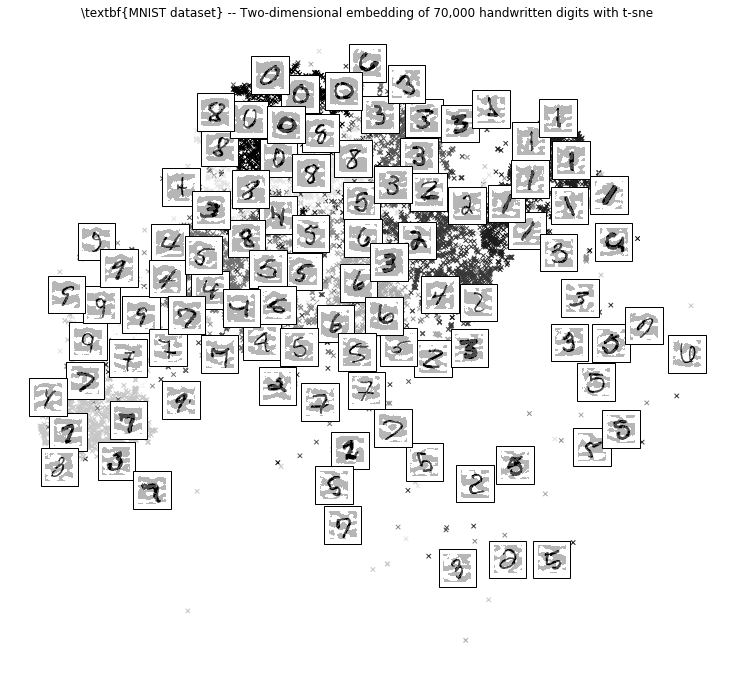

In [102]:
# plot adversarial instances
plot_mnist(X_test_adv, Y_test.argmax(1), vis_data[10000:], 't-sne', min_dist=20.0)

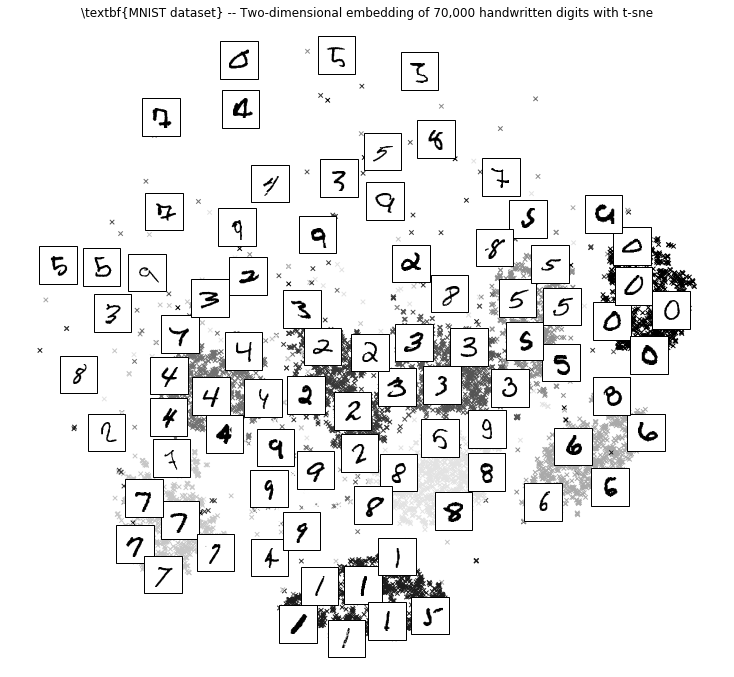

In [104]:
X